# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
from sklearn.metrics import f1_score
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 150
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"


### Dataset


In [4]:

def convert_to_rgb(x):
    return x.repeat(3, 1, 1)



transform_mnist_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(convert_to_rgb), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_mnist_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(convert_to_rgb), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.FashionMNIST(root='../data', train=True,
                                              download=True, transform=transform_mnist_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=2)

test_set = torchvision.datasets.FashionMNIST(root='../data', train=False,
                                             download=True, transform=transform_mnist_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False, num_workers=2)

class_names = train_set.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 第一层卷积层，3个输入通道（对于RGB图像），32个输出通道，3x3卷积核
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # 第二层卷积层
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # 第三层卷积层
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # 最大池化层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Dropout层
        self.dropout = nn.Dropout(0.5)
        # 全连接层
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10) # 10个输出类别

    def forward(self, x):
        # 通过卷积层、批量归一化层、激活函数、池化层和dropout层
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # 扁平化特征图
        x = x.view(-1, 128 * 3 * 3)
        # 通过dropout层和全连接层
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

### Optimizer

In [7]:
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
from torch.optim import lr_scheduler

# 定义warm-up学习率调度器
def warmup_lr_scheduler(optimizer, warmup_epochs, multiplier):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (multiplier - 1.0) * epoch / warmup_epochs + 1.0
        return 1.0

    return lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 在训练代码中引入warm-up学习率调度器
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
warmup_epochs = NUM_EPOCHS//5
multiplier = 10
scheduler = warmup_lr_scheduler(optimizer, warmup_epochs, multiplier)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
def train_batch(model, image, target):
    output = model(image)
    #print("Output size:", output.size())  # Add this line to check the output size
    loss = criterion(output, target)
    return output, loss

In [9]:
criterion = nn.CrossEntropyLoss()


def one_hot_encoding(target, num_classes):
    return F.one_hot(target, num_classes=num_classes).float()



In [10]:
def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

### Model Training

In [11]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []
start_time = time.time()  # 记录开始时间
all_preds = []
all_targets = []
# 日志文件
log_file = 'training_log.txt'
for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        
        outputs, loss = train_batch(model, image, target)
        #########################
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    #########
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(target.cpu().numpy())
    f1 = f1_score(all_targets, all_preds, average='weighted')
    print(f"f1 score in {epoch}th epoch is {f1}")

############
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            ##################
          #  target_one_hot = one_hot_encoding(target, 10)  # 转换成 one-hot 编码
            outputs, loss = test_batch(model, image, target)
          #  outputs, loss = test_batch(model, image, target_one_hot)  # 使用 one-hot 编码后的目标
            #######################
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
    with open(log_file, 'a') as f:
        f.write(f'Epoch {epoch+1}/{NUM_EPOCHS}\n')
        f.write(f'Train Accuracy: {epoch_acc:.4f}%\n')
        f.write(f'Test Accuracy: {val_acc:.4f}%\n')
        f.write('\n')

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
end_time = time.time()  # 记录结束时间
duration = end_time - start_time  # 计算训练时间
print(f"训练模型用时：{duration}秒")


Epoch: 1/150 Train Loss: 0.0132 Acc: 0.5012
f1 score in 0th epoch is 0.7593527674863486
Begin test......
Test Loss: 0.0085 Acc: 0.7363
Epoch: 2/150 Train Loss: 0.0072 Acc: 0.7210
f1 score in 1th epoch is 0.7753869560313359
Begin test......
Test Loss: 0.0057 Acc: 0.7693
Epoch: 3/150 Train Loss: 0.0055 Acc: 0.7618
f1 score in 2th epoch is 0.7821953403165275
Begin test......
Test Loss: 0.0047 Acc: 0.7891
Epoch: 4/150 Train Loss: 0.0048 Acc: 0.7860
f1 score in 3th epoch is 0.7851883051227412
Begin test......
Test Loss: 0.0042 Acc: 0.8072
Epoch: 5/150 Train Loss: 0.0043 Acc: 0.8076
f1 score in 4th epoch is 0.8029680493122766
Begin test......
Test Loss: 0.0038 Acc: 0.8243
Epoch: 6/150 Train Loss: 0.0039 Acc: 0.8224
f1 score in 5th epoch is 0.7955295927497983
Begin test......
Test Loss: 0.0035 Acc: 0.8433
Epoch: 7/150 Train Loss: 0.0036 Acc: 0.8356
f1 score in 6th epoch is 0.8093658000999113
Begin test......
Test Loss: 0.0033 Acc: 0.8510
Epoch: 8/150 Train Loss: 0.0034 Acc: 0.8466
f1 score in

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [12]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [13]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
input_tensor = input.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    probabilities = F.softmax(output, dim=1)
    predict_label = torch.argmax(probabilities)
# predict_label = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


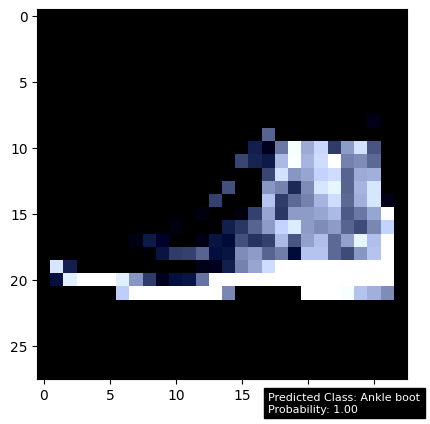

Print probabilities for each class:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0002
Shirt: 0.0000
Sneaker: 0.0003
Bag: 0.0000
Ankle boot: 0.9996


In [14]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0][predict_label.item()]
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0][i].item():.4f}')

In [15]:
for i in np.array(training_acc):
    print(f"{i:.5f}",end=',')
print("\n\n")
for i in np.array(testing_acc):
    print(f"{i:.5f}",end=',')

0.50120,0.72098,0.76178,0.78597,0.80760,0.82242,0.83563,0.84658,0.85547,0.86053,0.86700,0.87195,0.87667,0.88062,0.88402,0.88728,0.88973,0.89217,0.89637,0.90028,0.90105,0.90255,0.90575,0.90673,0.90908,0.91058,0.91108,0.91422,0.91737,0.91723,0.92443,0.92452,0.92412,0.92547,0.92735,0.92720,0.92722,0.92655,0.92730,0.92777,0.92778,0.92798,0.92905,0.92753,0.92987,0.92943,0.93013,0.92998,0.92998,0.93078,0.93042,0.93147,0.93032,0.93043,0.93172,0.93040,0.93182,0.93145,0.93020,0.93170,0.93238,0.93372,0.93290,0.93403,0.93375,0.93242,0.93422,0.93495,0.93395,0.93433,0.93413,0.93437,0.93527,0.93495,0.93522,0.93598,0.93555,0.93532,0.93447,0.93637,0.93668,0.93640,0.93688,0.93667,0.93712,0.93835,0.93670,0.93777,0.93765,0.93793,0.93840,0.93847,0.93950,0.93850,0.93863,0.93823,0.93805,0.94007,0.93928,0.93950,0.93940,0.93833,0.93962,0.94003,0.94073,0.94068,0.94165,0.94148,0.94112,0.94110,0.94143,0.94108,0.94098,0.94193,0.94195,0.94263,0.94212,0.94300,0.94135,0.94333,0.94288,0.94335,0.94353,0.94380,0.94320,

ValueError: x and y must have same first dimension, but have shapes (300,) and (150,)

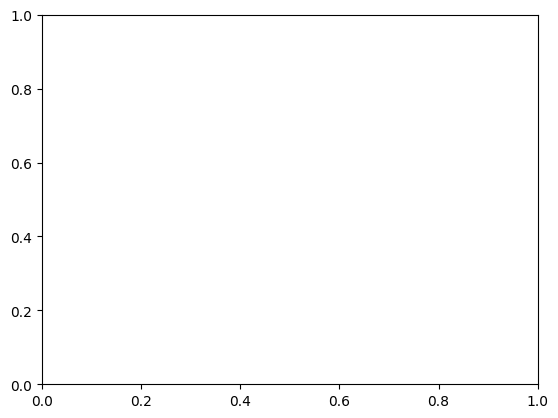

In [16]:
fig, ax = plt.subplots()
epochs = list(range(1, 301))
line1 = ax.plot(epochs, np.array(training_acc), label="train acc")
line2 = ax.plot(epochs, np.array(testing_acc), label="test acc")
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.grid(True)
ax.set_ylim(0, 1)
ax.legend()
plt.show()